## Exponential Smoothing Real Data

In [1]:
# install and load necessary packages
!pip install seaborn
!pip install --upgrade --no-deps statsmodels

import pyspark
from datetime import datetime
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

print('Python version ' + sys.version)
print('Spark version: ' + pyspark.__version__)

Requirement already up-to-date: statsmodels in /opt/app-root/lib/python3.6/site-packages (0.9.0)
Python version 3.6.3 (default, Mar 20 2018, 13:50:41) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-16)]
Spark version: 2.2.1


In [2]:
%env DH_CEPH_KEY = DTG5R3EEWN9JBYJZH0DF
%env DH_CEPH_SECRET = pdcEGFERILlkRDGrCSxdIMaZVtNCOKvYP4Gf2b2x
%env DH_CEPH_HOST = http://storage-016.infra.prod.upshift.eng.rdu2.redhat.com:8080
%env METRIC_NAME = kubelet_docker_operations_latency_microseconds
%env LABEL =

label = os.getenv("LABEL")
where_labels = {}#"metric.group=route.openshift.io"}
metric_name = str(os.getenv("METRIC_NAME"))
print(metric_name)

env: DH_CEPH_KEY=DTG5R3EEWN9JBYJZH0DF
env: DH_CEPH_SECRET=pdcEGFERILlkRDGrCSxdIMaZVtNCOKvYP4Gf2b2x
env: DH_CEPH_HOST=http://storage-016.infra.prod.upshift.eng.rdu2.redhat.com:8080
env: METRIC_NAME=kubelet_docker_operations_latency_microseconds
env: LABEL=
kubelet_docker_operations_latency_microseconds


### Establish Connection to Spark Cluster

set configuration so that the Spark Cluster communicates with Ceph and reads a chunk of data.

In [3]:
import string 
import random

# Set the configuration
# random string for instance name
inst = ''.join(random.choices(string.ascii_uppercase + string.digits, k=4))
AppName = inst + ' - Ceph S3 Prometheus JSON Reader'
conf = pyspark.SparkConf().setAppName(AppName).setMaster('spark://spark-cluster.dh-prod-analytics-factory.svc:7077')
print("Application Name: ", AppName)

# specify number of nodes need (1-5)
conf.set("spark.cores.max", "88")

# specify Spark executor memory (default is 1gB)
conf.set("spark.executor.memory", "400g")

# Set the Spark cluster connection
sc = pyspark.SparkContext.getOrCreate(conf) 

# Set the Hadoop configurations to access Ceph S3
import os
(ceph_key, ceph_secret, ceph_host) = (os.getenv('DH_CEPH_KEY'), os.getenv('DH_CEPH_SECRET'), os.getenv('DH_CEPH_HOST'))
ceph_key = 'DTG5R3EEWN9JBYJZH0DF'
ceph_secret = 'pdcEGFERILlkRDGrCSxdIMaZVtNCOKvYP4Gf2b2x'
ceph_host = 'http://storage-016.infra.prod.upshift.eng.rdu2.redhat.com:8080'
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", ceph_key) 
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", ceph_secret) 
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", ceph_host) 

#Get the SQL context
sqlContext = pyspark.SQLContext(sc)

Application Name:  1A0Q - Ceph S3 Prometheus JSON Reader


In [ ]:
#Read the Prometheus JSON BZip data
jsonUrl = "s3a://DH-DEV-PROMETHEUS-BACKUP/prometheus-openshift-devops-monitor.1b7d.free-stg.openshiftapps.com/"+metric_name+"/"

jsonFile = sqlContext.read.option("multiline", True).option("mode", "PERMISSIVE").json(jsonUrl)

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import TimestampType

# create function to convert POSIX timestamp to local date
def convert_timestamp(t):
    return datetime.fromtimestamp(float(t))

def format_df(df):
    #reformat data by timestamp and values
    df = df.withColumn("values", F.explode(df.values))
    
    df = df.withColumn("timestamp", F.col("values").getItem(0))
    
    df = df.withColumn("values", F.col("values").getItem(1))

    # drop null values
    df = df.na.drop(subset=["values"])
    
    # cast values to int
    df = df.withColumn("values", df.values.cast("int"))
    #df = df.withColumn("timestamp", df.values.cast("int"))

    # define function to be applied to DF column
    udf_convert_timestamp = F.udf(lambda z: convert_timestamp(z), TimestampType())

    df = df.na.drop(subset=["timestamp"])
    # convert timestamp values to datetime timestamp
    df = df.withColumn("timestamp", udf_convert_timestamp("timestamp"))

    # drop null values
    df = df.na.drop(subset=["values"])
    
    # calculate log(values) for each row
    #df = df.withColumn("log_values", F.log(df.values))
    
    return df

In [ ]:
def extract_from_json(json, name, select_labels, where_labels):
    #Register the created SchemaRDD as a temporary variable
    json.registerTempTable(name)
    
    #Filter the results into a data frame

    query = "SELECT values"
    
    # check if select labels are specified and add query condition if appropriate
    if len(select_labels) > 0:
        query = query + ", " + ", ".join(select_labels)
        
    query = query + " FROM " + name
    
    # check if where labels are specified and add query condition if appropriate
    if len(where_labels) > 0:
        query = query + " WHERE " + " AND ".join(where_labels)

    print("SQL QUERRY: ", query)
    df = sqlContext.sql(query)

    #sample data to make it more manageable
    #data = data.sample(False, fraction = 0.05, seed = 0)
    # TODO: get rid of this hack
    #df = sqlContext.createDataFrame(df.head(1000), df.schema)
    
    return format_df(df)

In [ ]:
if label != "":
    select_labels = ['metric.' + label]
else:
    select_labels = []
    
where_labels = {"metric.quantile='0.9'","metric.hostname='free-stg-master-03fb6'"}
# get data and format
df = extract_from_json(jsonFile, metric_name, select_labels, where_labels)
select_labels = []


In [ ]:
df_pd = df.toPandas()


In [ ]:
df_pd = df_pd[["values","timestamp"]]
df_pd

In [ ]:
df_pd.sort_values(by='timestamp')
df_pd.set_index("timestamp")
train_frame = df_pd[0 : int(0.7*len(df_pd))]
test_frame = df_pd[int(0.7*len(df_pd)) : ]

In [ ]:
sc.stop()

In [103]:
df_pd_trimmed = df_pd[df_pd["timestamp"] > datetime(2018,6,16,3,14)]
df_pd_trimmed = df_pd_trimmed[df_pd_trimmed["timestamp"] < datetime(2018,6,21,3,14)]
train_frame = df_pd_trimmed[0 : int(0.7*len(df_pd_trimmed))]
test_frame = df_pd_trimmed[int(0.7*len(df_pd_trimmed)) : ]

In [105]:
train_frame += 1

ValueError: Cannot add integral value to Timestamp without freq.

### Triple Exponential Smoothing (Holt Winters Method)

inspiration: https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/exponential_smoothing.ipynb

In [26]:
!pip install patsy
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import pandas as pd

In [93]:
df_series = pd.Series(train_frame["values"], name='values',index=train_frame["timestamp"])

ValueError: cannot reindex from a duplicate axis

In [91]:
df_series

timestamp
2018-06-19 18:15:59    34348
2018-06-19 18:16:59    34348
2018-06-19 18:17:59    34348
2018-06-19 18:18:59    34348
2018-06-19 18:19:59    34348
2018-06-19 18:20:59    34348
2018-06-19 18:21:59    34348
2018-06-19 18:22:59    34348
2018-06-19 18:23:59    34348
2018-06-19 18:15:59     5857
2018-06-19 18:16:59     5857
2018-06-19 18:17:59     5857
2018-06-19 18:18:59     5857
2018-06-19 18:19:59     5857
2018-06-19 18:20:59     5857
2018-06-19 18:21:59     5857
2018-06-19 18:22:59     5857
2018-06-19 18:23:59     5857
2018-06-18 23:59:59     2025
2018-06-19 00:00:59     2025
2018-06-19 00:01:59     2025
2018-06-19 00:02:59     1904
2018-06-19 00:03:59     1904
2018-06-19 00:04:59     1904
2018-06-19 00:05:59     1904
2018-06-19 00:06:59     1904
2018-06-19 00:07:59     1904
2018-06-19 00:08:59     1904
2018-06-19 00:09:59     1904
2018-06-19 00:10:59     1904
                       ...  
2018-06-17 13:37:59    14978
2018-06-17 13:38:59    14270
2018-06-17 13:39:59    14270
2018

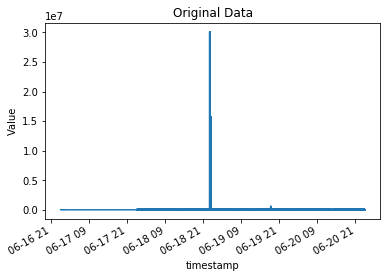

In [63]:
ax=df_series.plot(title="Original Data")
ax.set_ylabel("Value")
plt.show()

/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


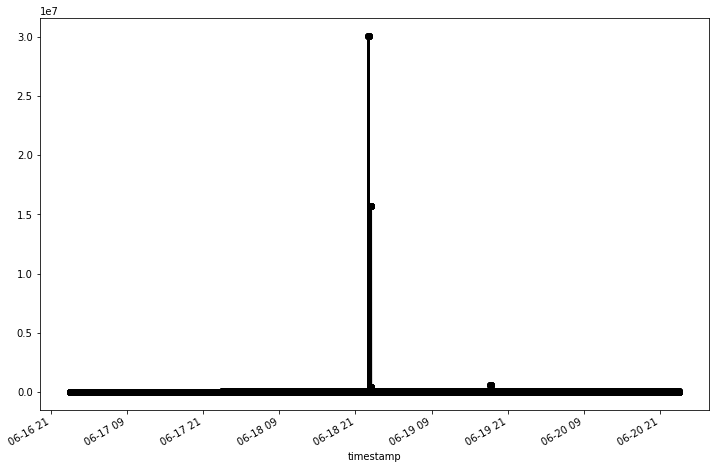

ValueError: view limit minimum -16120.499999421292 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fe7afabb7b8> (for post_execute):


ValueError: view limit minimum -16120.499999421292 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -16120.499999421292 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 864x576 with 1 Axes>

In [72]:
fit1  =  SimpleExpSmoothing(df_series).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(3).rename(r'$\alpha=0.2$')
ax = df_series.plot(marker='o', color='black', figsize=(12,8))
plt.show()
ax1 = fcast1.plot(marker='o', color='blue', legend=True, figsize=(12,8))
fit1.fittedvalues.plot(marker='o', ax=ax1, color='green')
plt.show()

/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


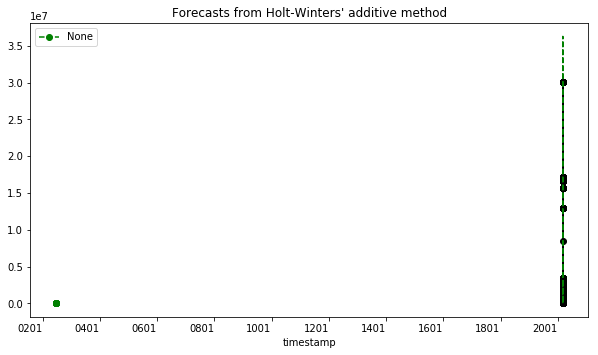

In [53]:
fit2 = ExponentialSmoothing(df_series, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"] = [fit2.params[p] for p in params] + [fit2.sse]
ax = df_series.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' additive method" )
fit2.fittedvalues.plot(ax=ax, style='--', color='green')
fit2.forecast(8).plot(ax=ax, style='--', marker='o', color='green', legend=True)
plt.show()

/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


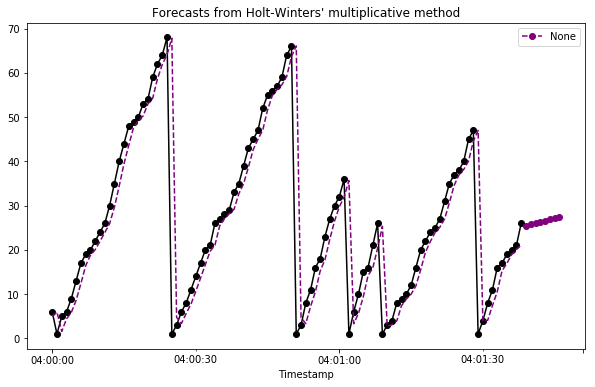

In [19]:
fit2 = ExponentialSmoothing(df_series, seasonal_periods=4, trend='add', seasonal='mult').fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
ax = df_series.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
fit2.fittedvalues.plot(ax=ax, style='--', color='purple')
fit2.forecast(8).plot(ax=ax, style='--', marker='o', color='purple', legend=True)
plt.show()